# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *
from modules.data_import import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam', 'do':0.1}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [5]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"))

def reconvert_event(in_data):
    move_to_cartesian(in_data, 'PRI_tau', drop=False)
    move_to_cartesian(in_data, 'PRI_lep', drop=False)
    move_to_cartesian(in_data, 'PRI_jet_leading', drop=False)
    move_to_cartesian(in_data, 'PRI_jet_subleading', drop=False)
    move_to_cartesian(in_data, 'PRI_met', z=False)

id = 19
nom = pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1]

z_flip = nom.copy()
z_flip_event(z_flip)
reconvert_event(z_flip)

rot = nom.copy()
rotate_event(rot)
reconvert_event(rot)

rot_y = nom.copy()
rotate_event(rot_y)
y_flip_event(rot_y)
reconvert_event(rot_y)

rot_yz = nom.copy()
rotate_event(rot_yz)
y_flip_event(rot_yz)
z_flip_event(rot_yz)
reconvert_event(rot_yz)

comp_events([nom, rot, rot_y, rot_yz])

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


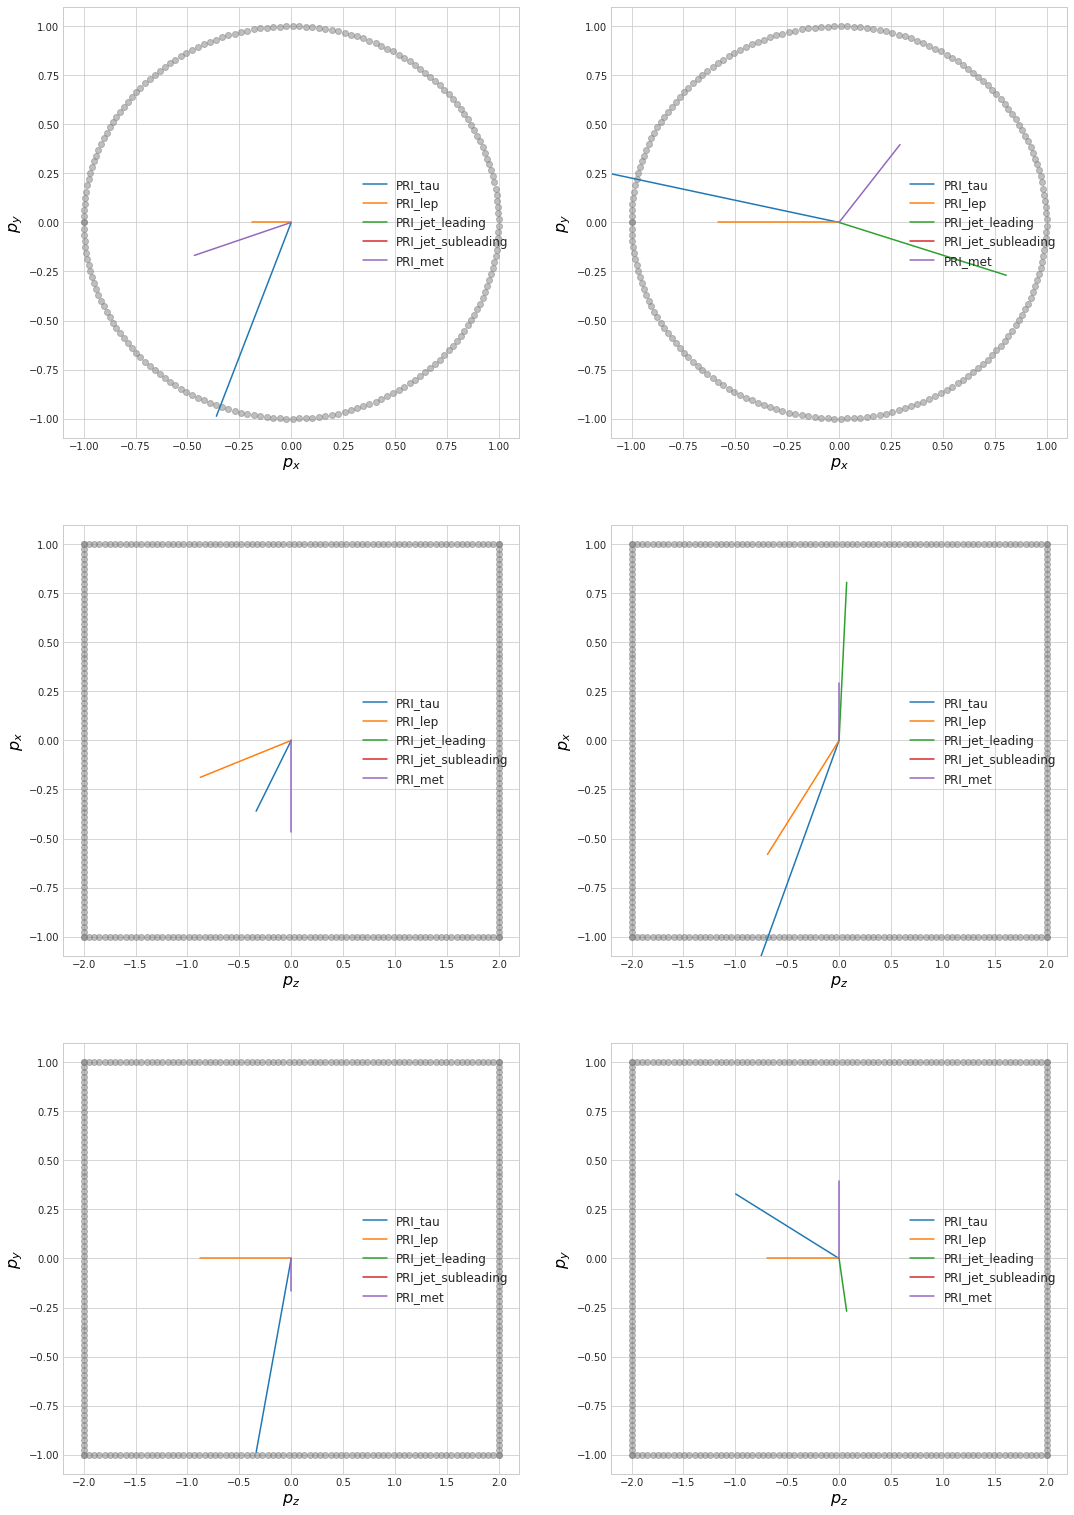

In [6]:
id = 0
pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1]
comp_events([pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1],
             pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id+1:id+2]])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 22.644s 


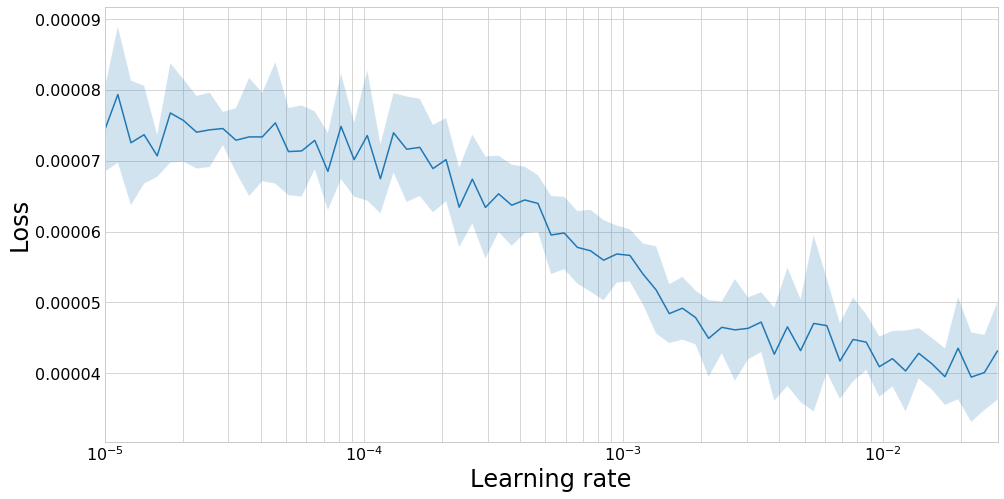

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [8]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

In [9]:
model_gen_params

{'version': 'modelSwish',
 'n_in': 30,
 'compile_args': {'loss': 'binary_crossentropy',
  'optimizer': 'adam',
  'do': 0.1,
  'lr': 0.002,
  'amsgrad': False,
  'beta_1': 0.9},
 'mode': 'classifier'}

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138090). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7470666976421804e-05
2 New best found: 3.4846336452932726e-05
3 New best found: 3.4694479502666905e-05
4 New best found: 3.411537920273443e-05
5 New best found: 3.360559530161515e-05
6 New best found: 3.344505960049344e-05
7 New best found: 3.326592424170883e-05
9 New best found: 3.3173305973484744e-05
10 New best found: 3.281597971875828e-05
13 New best found: 3.257080856552676e-05
14 New best found: 3.253155807022413e-05
15 New best found: 3.251665676206329e-05
23 New best found: 3.247242077358248e-05
24 New best found: 3.224792153738681e-05
26 New best found: 3.210645806721133e-05
28 New best found: 3.200492713487934e-05
30 New best found: 3.200170001995136e-05
31 New best found: 3.199907711035117e-05
46 New best found: 3.1990700178774786e-05
47 New best found: 3.19473166781716e-05
48 New best found: 3.1942844556714846e-05
50 New best found: 3.188912474254475e-05
51 New best found: 3.182275948010664e-05
55 New best found: 3.176281280784619e-05
86 New best found: 

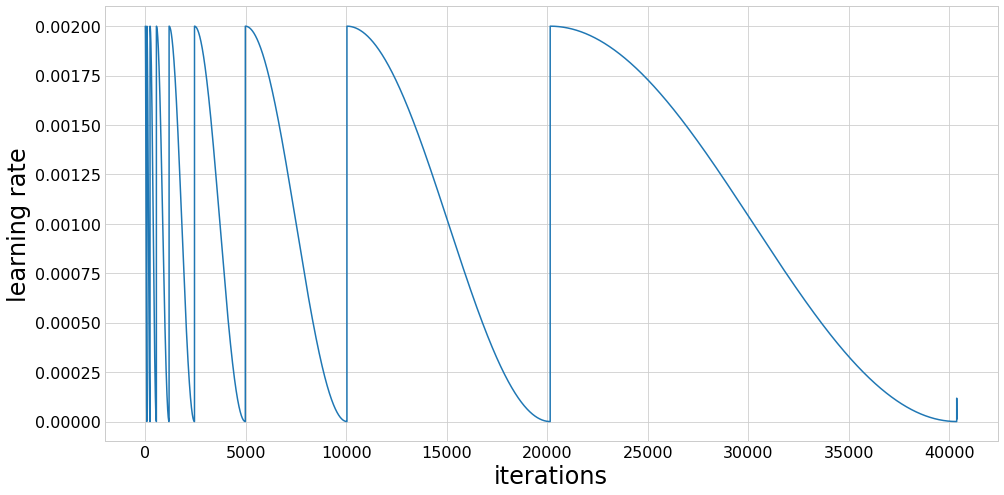

Fold took 498.997s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151832). Check your callbacks.
  % delta_t_median)


1 New best found: 3.740532793185602e-05
2 New best found: 3.53158623173505e-05
3 New best found: 3.492429396407285e-05
5 New best found: 3.42280878316418e-05
6 New best found: 3.3978576757373955e-05
7 New best found: 3.3837636939609706e-05
9 New best found: 3.354748043897531e-05
10 New best found: 3.336153268870074e-05
11 New best found: 3.321416787656686e-05
12 New best found: 3.3108341769855196e-05
13 New best found: 3.296441546054219e-05
14 New best found: 3.2963626110458885e-05
15 New best found: 3.294661726453243e-05
23 New best found: 3.2900931122291405e-05
24 New best found: 3.27937395154511e-05
25 New best found: 3.2667741920617794e-05
27 New best found: 3.253901466018648e-05
29 New best found: 3.250115309728001e-05
30 New best found: 3.2485275468302863e-05
31 New best found: 3.248275286152755e-05
48 New best found: 3.241916850314429e-05
52 New best found: 3.238407274368621e-05
54 New best found: 3.230116364889103e-05
55 New best found: 3.2290456016192185e-05
56 New best found:

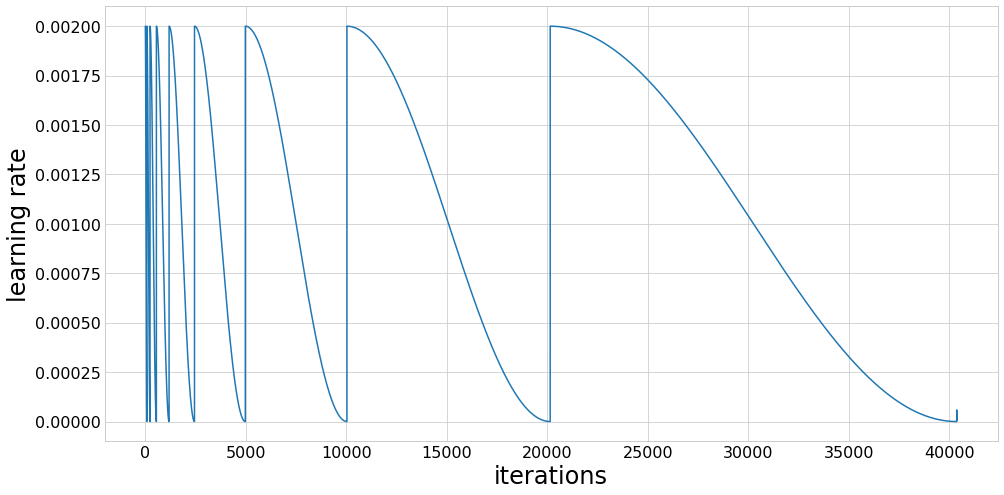

Fold took 510.193s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.374027). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187466). Check your callbacks.
  % delta_t_median)


1 New best found: 3.686975345092981e-05
2 New best found: 3.4696818597217065e-05
3 New best found: 3.425106536381605e-05
4 New best found: 3.381920541894944e-05
5 New best found: 3.363985300927836e-05
6 New best found: 3.3079123928628007e-05
7 New best found: 3.2968026877956485e-05
10 New best found: 3.2611778015467755e-05
11 New best found: 3.252358427367134e-05
12 New best found: 3.229161961722861e-05
13 New best found: 3.219124408165864e-05
14 New best found: 3.21696919643899e-05
15 New best found: 3.215913815094319e-05
23 New best found: 3.2096311312102276e-05
24 New best found: 3.199807522368132e-05
25 New best found: 3.1961090338357435e-05
26 New best found: 3.1950201669871867e-05
27 New best found: 3.186187848822922e-05
28 New best found: 3.177080162212439e-05
30 New best found: 3.176837170040381e-05
31 New best found: 3.175963007854831e-05
41 New best found: 3.1626784930621414e-05
54 New best found: 3.157730300971857e-05
55 New best found: 3.15567541691118e-05
56 New best found

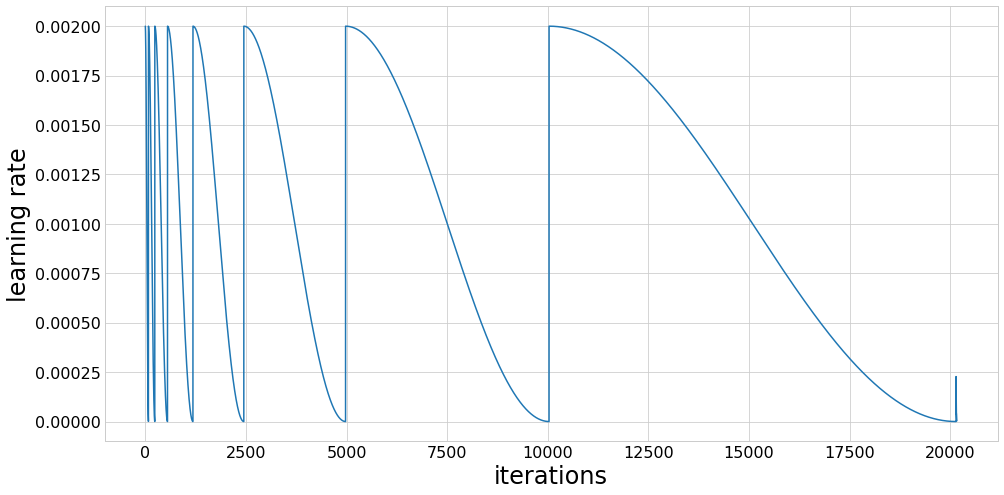

Fold took 279.918s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.420933). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210812). Check your callbacks.
  % delta_t_median)


1 New best found: 3.738886400242336e-05
2 New best found: 3.502893727272749e-05
3 New best found: 3.464418552757707e-05
4 New best found: 3.3556436926301104e-05
5 New best found: 3.328232802086859e-05
6 New best found: 3.29341963501065e-05
7 New best found: 3.291433102713199e-05
10 New best found: 3.275759384705452e-05
11 New best found: 3.2574033756100105e-05
12 New best found: 3.224521153751994e-05
13 New best found: 3.219543531304225e-05
14 New best found: 3.2107728379924086e-05
15 New best found: 3.2091444708930794e-05
23 New best found: 3.190798644573078e-05
24 New best found: 3.186127346270951e-05
26 New best found: 3.170489998155972e-05
28 New best found: 3.162683353075408e-05
46 New best found: 3.1622138668899425e-05
49 New best found: 3.161612429103116e-05
51 New best found: 3.144645971697173e-05
53 New best found: 3.139456222270383e-05
54 New best found: 3.1380586791783574e-05
55 New best found: 3.1364849094825334e-05
56 New best found: 3.134427511977265e-05
58 New best found

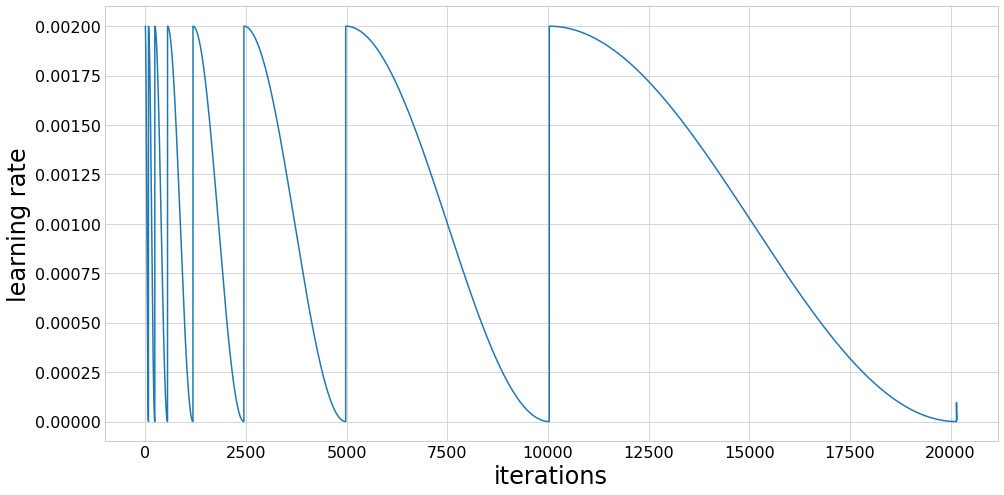

Fold took 275.368s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.401121). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200974). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8307166834420056e-05
2 New best found: 3.65051995999238e-05
3 New best found: 3.593354621116305e-05
5 New best found: 3.456476211431436e-05
6 New best found: 3.419444470564485e-05
7 New best found: 3.4134657330287155e-05
9 New best found: 3.408107988216216e-05
10 New best found: 3.392975553870201e-05
11 New best found: 3.363318274787161e-05
12 New best found: 3.334290102138766e-05
13 New best found: 3.327385375741869e-05
14 New best found: 3.323103735456243e-05
22 New best found: 3.310654494198388e-05
23 New best found: 3.3045665852114324e-05
24 New best found: 3.2768265889171746e-05
27 New best found: 3.27449339805753e-05
29 New best found: 3.269538899330655e-05
30 New best found: 3.2689174594997895e-05
31 New best found: 3.268207005166914e-05
50 New best found: 3.261311146925436e-05
52 New best found: 3.2567880709393646e-05
56 New best found: 3.2497666084964295e-05
57 New best found: 3.2489171725319464e-05
58 New best found: 3.24674935778603e-05
59 New best found:

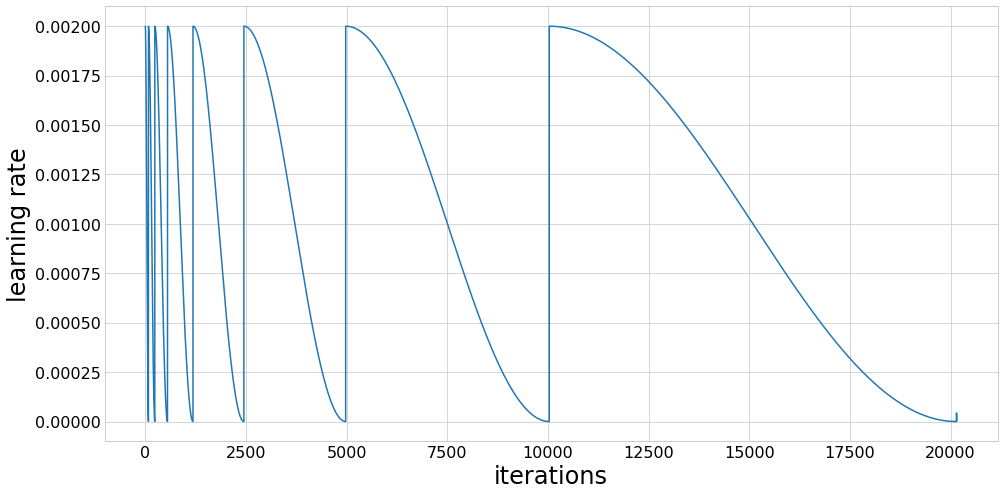

Fold took 286.789s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.424260). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212531). Check your callbacks.
  % delta_t_median)


1 New best found: 3.813486285944236e-05
2 New best found: 3.513473759230692e-05
3 New best found: 3.454000566125614e-05
5 New best found: 3.373935485869879e-05
6 New best found: 3.330613609869033e-05
9 New best found: 3.3232709285948656e-05
10 New best found: 3.273281830042834e-05
11 New best found: 3.2667527356534266e-05
12 New best found: 3.258185149607016e-05
13 New best found: 3.240956628942513e-05
14 New best found: 3.2317918597254905e-05
15 New best found: 3.2315506493614524e-05
22 New best found: 3.2256282717571594e-05
23 New best found: 3.214897154393839e-05
24 New best found: 3.211249255691655e-05
25 New best found: 3.199000348249683e-05
26 New best found: 3.1875659897195876e-05
28 New best found: 3.1834998845442894e-05
29 New best found: 3.1801910419017074e-05
50 New best found: 3.1773119098943424e-05
51 New best found: 3.172356995273731e-05
52 New best found: 3.166567293956177e-05
53 New best found: 3.1580537732952505e-05
56 New best found: 3.156410341034643e-05
59 New best 

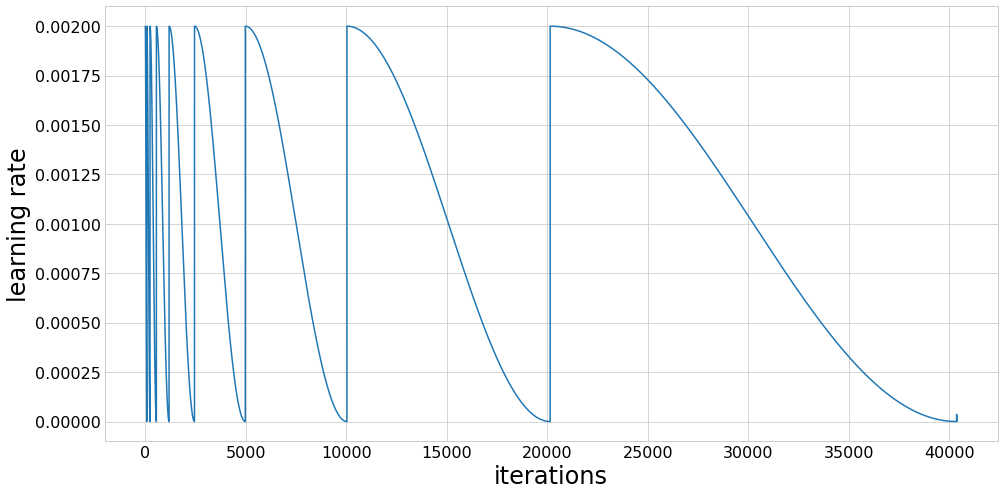

Fold took 560.214s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.456399). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228589). Check your callbacks.
  % delta_t_median)


1 New best found: 3.715750262527743e-05
2 New best found: 3.512633744314644e-05
3 New best found: 3.475687763225787e-05
4 New best found: 3.423247660976267e-05
5 New best found: 3.375059881426936e-05
6 New best found: 3.350225623936658e-05
7 New best found: 3.344550413570205e-05
11 New best found: 3.3384506141905634e-05
12 New best found: 3.3010693512795034e-05
13 New best found: 3.299422585600851e-05
14 New best found: 3.283577125540898e-05
15 New best found: 3.282412398066246e-05
23 New best found: 3.2523089706424045e-05
24 New best found: 3.249556224293598e-05
27 New best found: 3.245988178748401e-05
28 New best found: 3.240711566261297e-05
44 New best found: 3.2403922384557854e-05
45 New best found: 3.234218403392392e-05
49 New best found: 3.229743354830742e-05
50 New best found: 3.216718808677498e-05
54 New best found: 3.216619833679454e-05
55 New best found: 3.215560247421393e-05
57 New best found: 3.2150567721102966e-05
58 New best found: 3.213232964008361e-05
59 New best found:

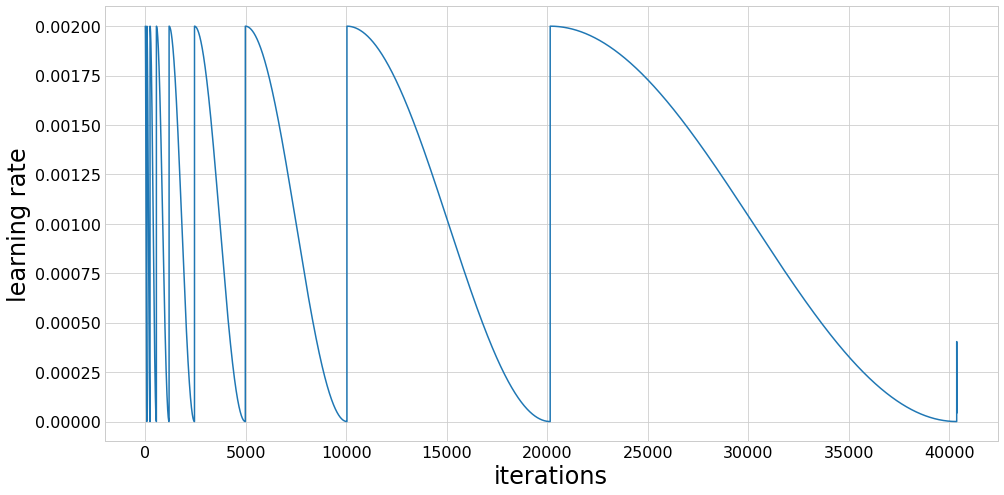

Fold took 571.382s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.489738). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245286). Check your callbacks.
  % delta_t_median)


1 New best found: 3.773111584050204e-05
2 New best found: 3.513666534158327e-05
3 New best found: 3.462150954813663e-05
5 New best found: 3.372164471884498e-05
6 New best found: 3.327567451385448e-05
7 New best found: 3.3148203469254244e-05
9 New best found: 3.310771198266962e-05
10 New best found: 3.292258836343207e-05
11 New best found: 3.288666072693363e-05
12 New best found: 3.2555584236414824e-05
13 New best found: 3.251878476728631e-05
14 New best found: 3.2410002007290435e-05
15 New best found: 3.2393677936116444e-05
24 New best found: 3.2362270508430115e-05
25 New best found: 3.2217319757930244e-05
26 New best found: 3.2038340546962856e-05
48 New best found: 3.20220147184459e-05
50 New best found: 3.196802354909849e-05
51 New best found: 3.193749646255082e-05
53 New best found: 3.186040329636558e-05
59 New best found: 3.185749550703216e-05
60 New best found: 3.181241064520864e-05
62 New best found: 3.180719985326627e-05
63 New best found: 3.180610442943967e-05
105 New best foun

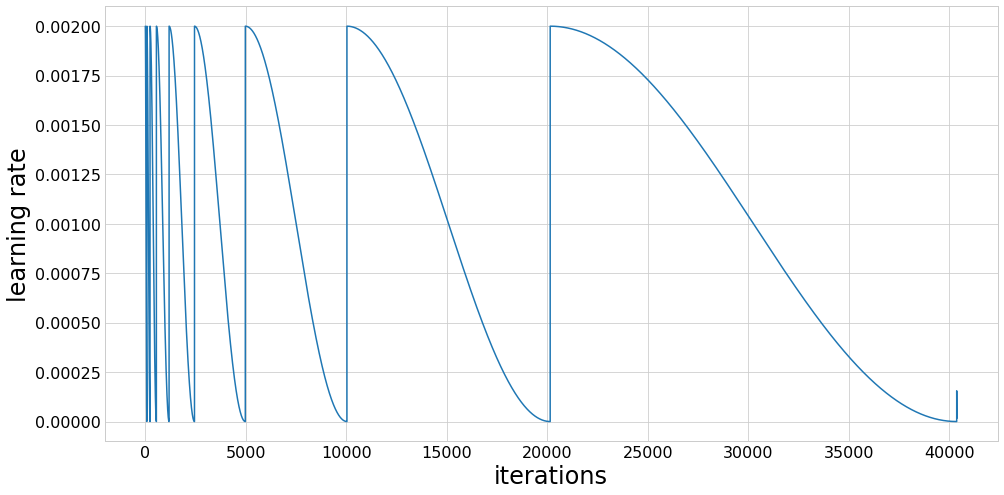

Fold took 576.140s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.526968). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.263877). Check your callbacks.
  % delta_t_median)


1 New best found: 3.795466325536836e-05
2 New best found: 3.530892362323357e-05
3 New best found: 3.478719045233447e-05
4 New best found: 3.407763617724413e-05
5 New best found: 3.3931385964388025e-05
6 New best found: 3.329168491909513e-05
7 New best found: 3.327591666165972e-05
11 New best found: 3.2922764134127644e-05
13 New best found: 3.28111952971085e-05
14 New best found: 3.269449106810498e-05
15 New best found: 3.267724815668771e-05
23 New best found: 3.25219452905003e-05
24 New best found: 3.244265031389659e-05
25 New best found: 3.244154643325601e-05
26 New best found: 3.2351653893420004e-05
27 New best found: 3.228724802174838e-05
29 New best found: 3.223533778436831e-05
30 New best found: 3.222120660211658e-05
31 New best found: 3.2219927629921584e-05
45 New best found: 3.212212434300454e-05
50 New best found: 3.21183126186952e-05
51 New best found: 3.2050572029402246e-05
54 New best found: 3.204955267428886e-05
56 New best found: 3.202784749009879e-05
58 New best found: 3.

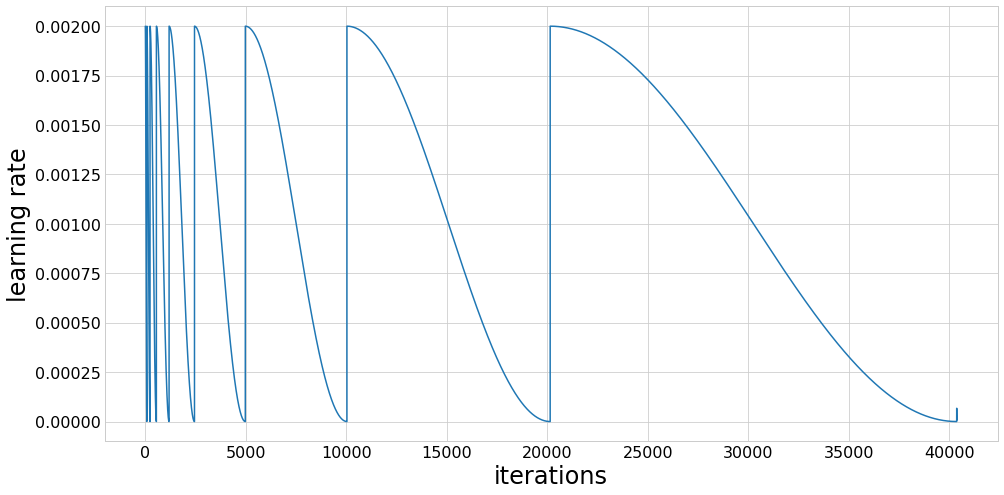

Fold took 588.609s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.583721). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.292255). Check your callbacks.
  % delta_t_median)


1 New best found: 3.740101686730958e-05
2 New best found: 3.542863120503069e-05
3 New best found: 3.467639472822154e-05
5 New best found: 3.3672713454514386e-05
6 New best found: 3.328229332050774e-05
7 New best found: 3.323806204945376e-05
11 New best found: 3.2964229258404244e-05
12 New best found: 3.288122981750286e-05
13 New best found: 3.263274423107659e-05
14 New best found: 3.25958074555124e-05
15 New best found: 3.25728576427035e-05
20 New best found: 3.252939715867391e-05
23 New best found: 3.249503357580413e-05
24 New best found: 3.232967065434904e-05
28 New best found: 3.226919904972281e-05
29 New best found: 3.2256383368773546e-05
30 New best found: 3.2234966056630996e-05
31 New best found: 3.223006785445316e-05
47 New best found: 3.2221818096941064e-05
49 New best found: 3.215396805796717e-05
50 New best found: 3.215309056946061e-05
53 New best found: 3.2129490976295424e-05
56 New best found: 3.2064235999110286e-05
57 New best found: 3.204462239672153e-05
58 New best found

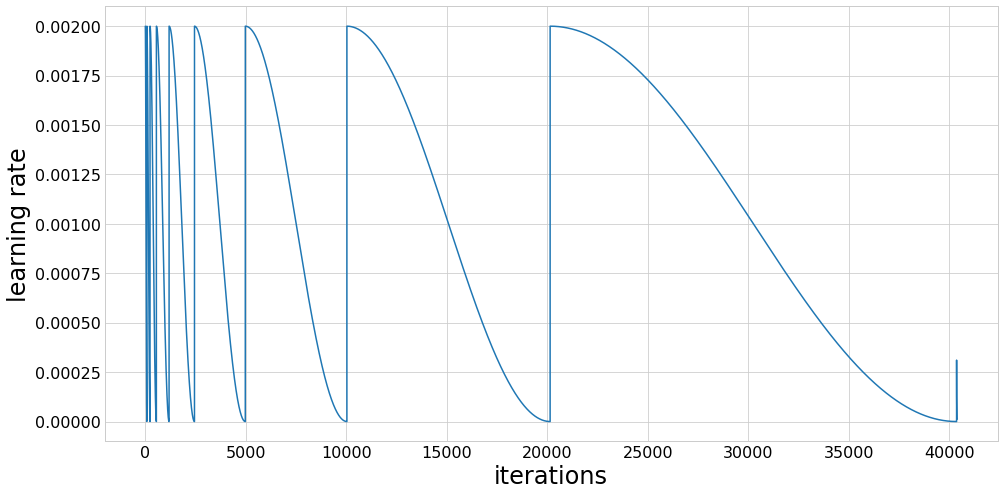

Fold took 601.464s


______________________________________
Training finished
Cross-validation took 4752.943s 


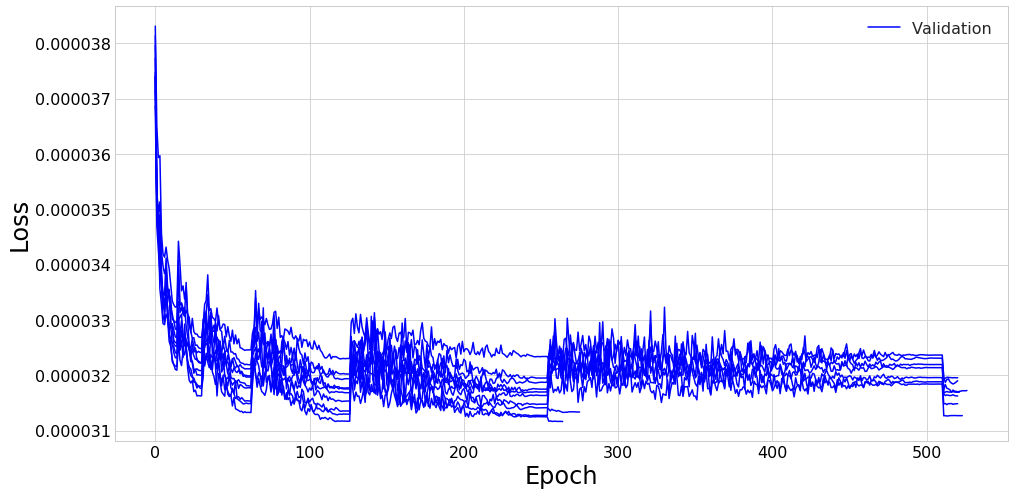

Mean loss = 3.16e-05 +- 1e-07
Mean wAUC = 0.0626 +- 0.0004
Mean AUC = 0.0975 +- 0.0004
Mean AMS = 3.97 +- 0.07
Mean cut = 0.957 +- 0.005
______________________________________



<Figure size 432x288 with 0 Axes>

In [10]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [11]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [12]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 3 with loss = 3.116479930758942e-05
Model 1 is 5 with loss = 3.126438236504328e-05
Model 2 is 2 with loss = 3.1329417477937045e-05
Model 3 is 0 with loss = 3.1453386549208344e-05
Model 4 is 7 with loss = 3.161496212963308e-05
Model 5 is 8 with loss = 3.168474414633238e-05
Model 6 is 9 with loss = 3.169166940725562e-05
Model 7 is 6 with loss = 3.183093726464201e-05
Model 8 is 1 with loss = 3.1939584624737164e-05
Model 9 is 4 with loss = 3.228838561335579e-05


## Response on validation data without TTA

In [13]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [14]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0023604234170168637s per sample

Predicting fold 2 out of 10
Prediction took 0.0004162676129490137s per sample

Predicting fold 3 out of 10
Prediction took 0.00040784816443920134s per sample

Predicting fold 4 out of 10
Prediction took 0.00041489192955195903s per sample

Predicting fold 5 out of 10
Prediction took 0.00041385921016335485s per sample

Predicting fold 6 out of 10
Prediction took 0.00040915461517870426s per sample

Predicting fold 7 out of 10
Prediction took 0.0004098026800900698s per sample

Predicting fold 8 out of 10
Prediction took 0.00041057074628770353s per sample

Predicting fold 9 out of 10
Prediction took 0.0004067999482154846s per sample

Predicting fold 10 out of 10
Prediction took 0.0004065889190882444s per sample



In [15]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [16]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9042220591253944, weighted 0.9364519107060959


Best cut at 0.9668627071667004 corresponds to AMS of 3.7894487018572707
Maximum AMS for data is 3.9074450095318296 at cut of 0.9633879065513611
CPU times: user 27.8 s, sys: 21.1 ms, total: 27.8 s
Wall time: 27.8 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


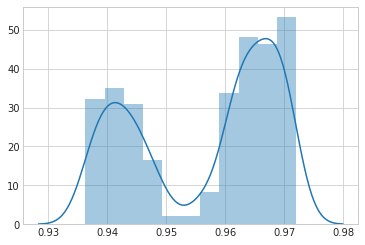

In [17]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.95668006 corresponds to AMS of 3.7910648484026988
Maximum AMS for data is 3.9074450095318296 at cut of 0.9633879065513611
CPU times: user 84.8 ms, sys: 42.2 ms, total: 127 ms
Wall time: 79.7 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


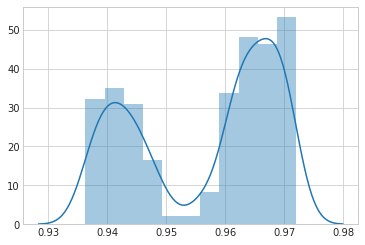

In [18]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [19]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [20]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0004065729419616136s per sample

Predicting fold 2 out of 10
Prediction took 0.00040698088146746156s per sample

Predicting fold 3 out of 10
Prediction took 0.0004093537053601308s per sample

Predicting fold 4 out of 10
Prediction took 0.00040693698034367776s per sample

Predicting fold 5 out of 10
Prediction took 0.0004149632123044946s per sample

Predicting fold 6 out of 10
Prediction took 0.00041109075549651276s per sample

Predicting fold 7 out of 10
Prediction took 0.0004055164820091291s per sample

Predicting fold 8 out of 10
Prediction took 0.0004094126310538162s per sample

Predicting fold 9 out of 10
Prediction took 0.0004054840825498104s per sample

Predicting fold 10 out of 10
Prediction took 0.00040751682496206325s per sample

CPU times: user 4min 23s, sys: 4.93 s, total: 4min 28s
Wall time: 3min 44s


In [21]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.6058685452071435 : 3.6934777154889047


(3.6058685452071435, 3.6934777154889047)

In [22]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.774687873838475 : 3.7796758351544018


(3.774687873838475, 3.7796758351544018)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)